In [137]:
## Visión por Computadora - Trabajo Práctico 3

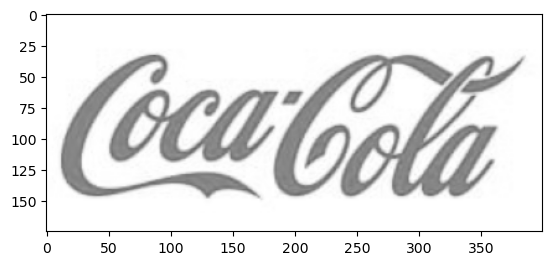

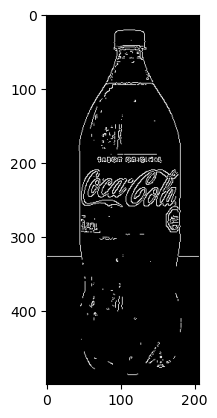

best_match.shape =  (30, 68)


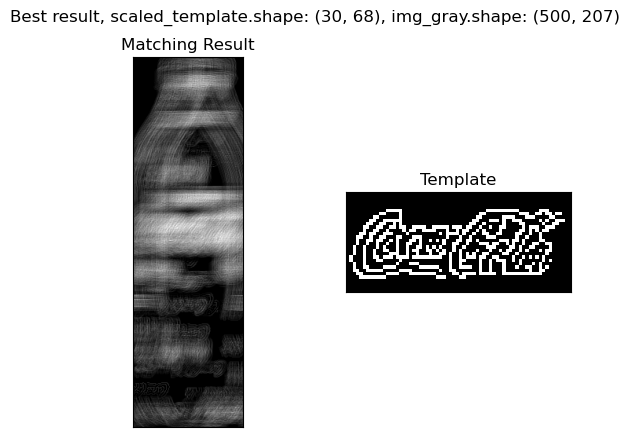

best_match.shape =  (72, 165)


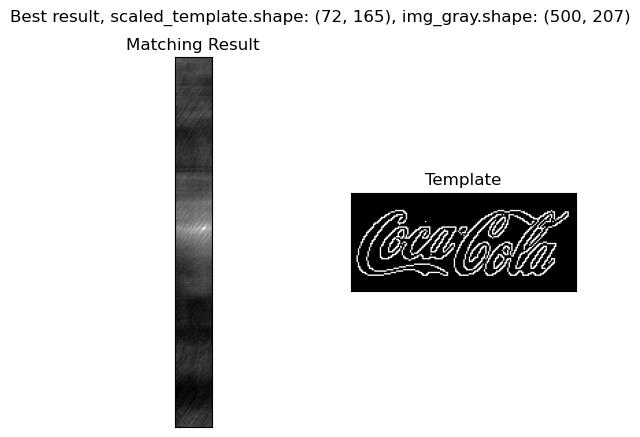

best_match.shape =  (74, 170)


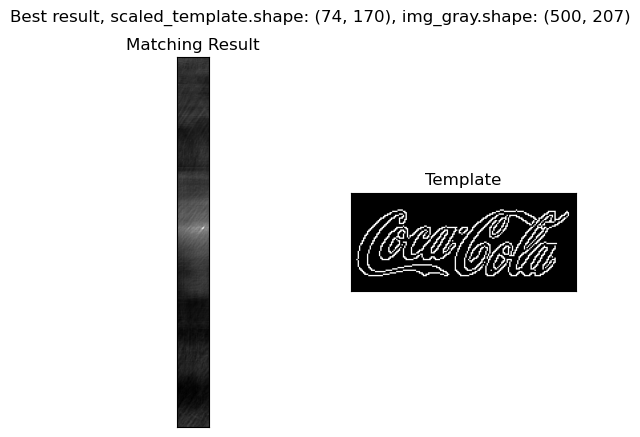

best_match.shape (final) =  (74, 170)


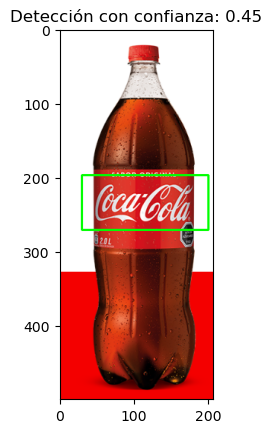

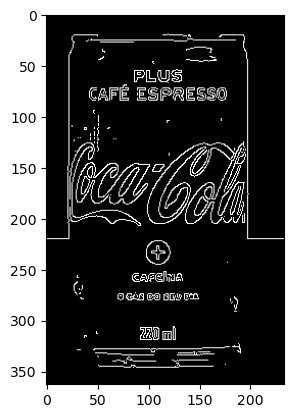

best_match.shape =  (30, 68)


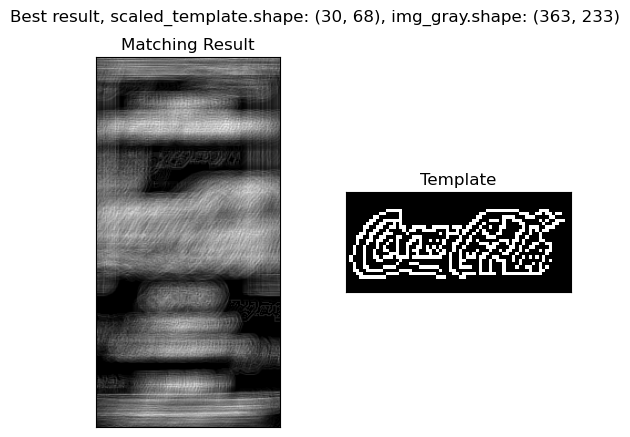

best_match.shape (final) =  (30, 68)


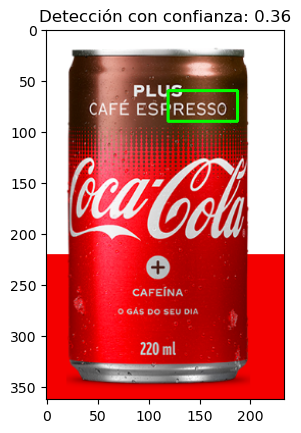

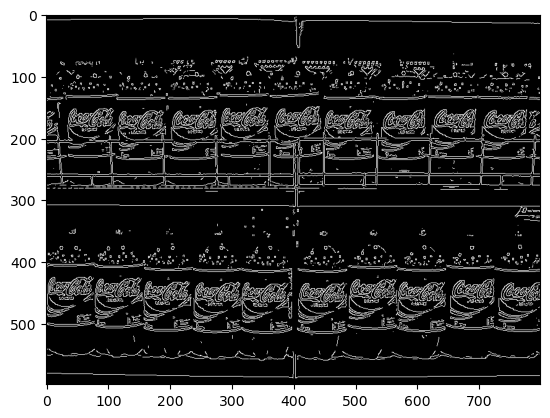

best_match.shape =  (30, 68)


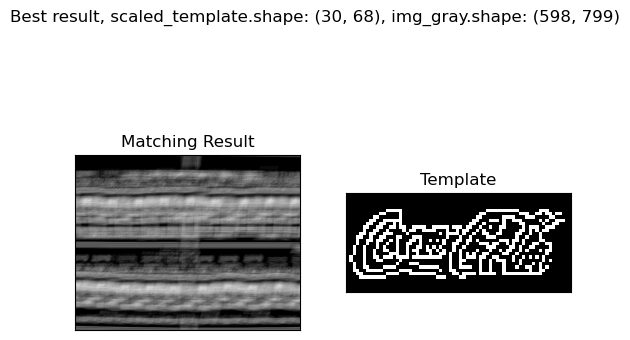

best_match.shape =  (32, 73)


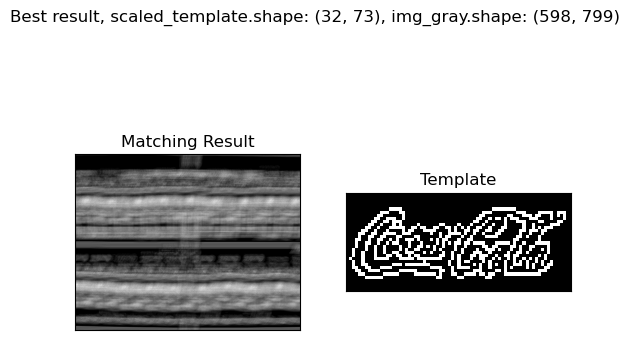

best_match.shape =  (34, 79)


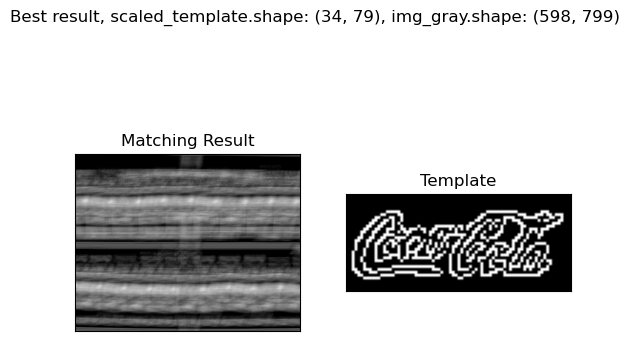

best_match.shape =  (37, 84)


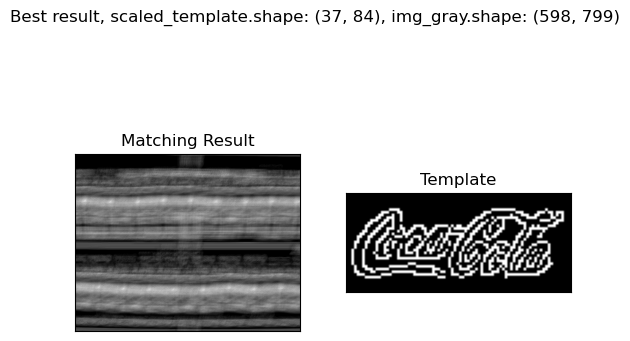

best_match.shape =  (42, 95)


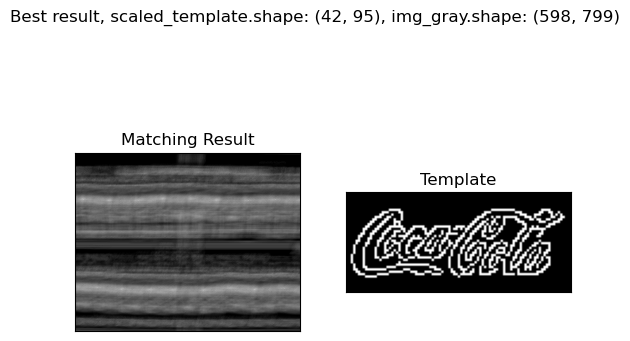

best_match.shape =  (44, 100)


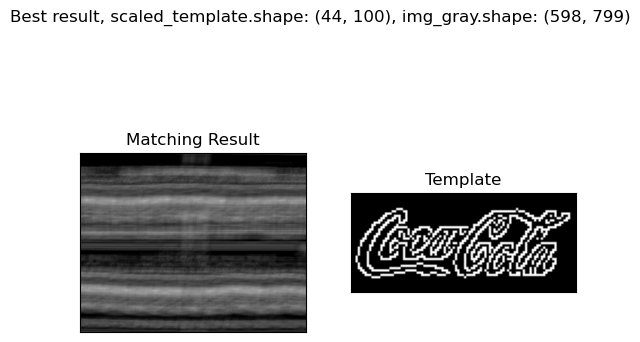

best_match.shape (final) =  (44, 100)


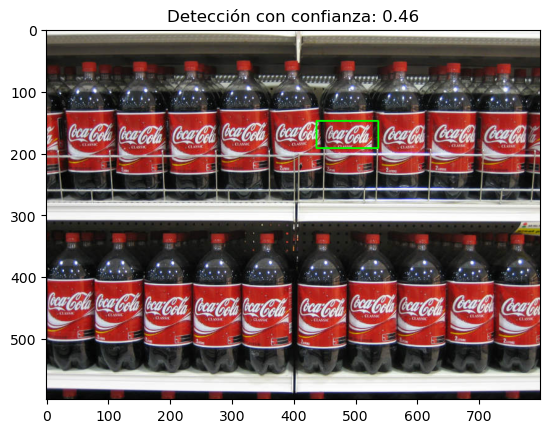

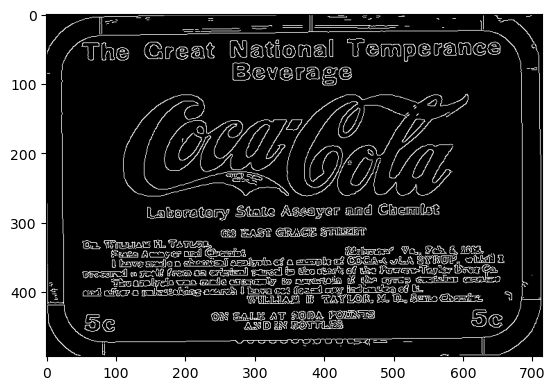

best_match.shape =  (30, 68)


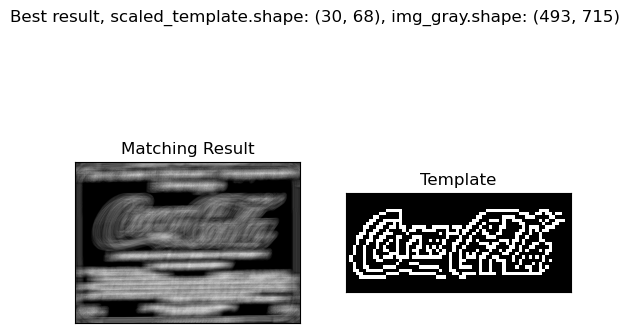

best_match.shape (final) =  (30, 68)


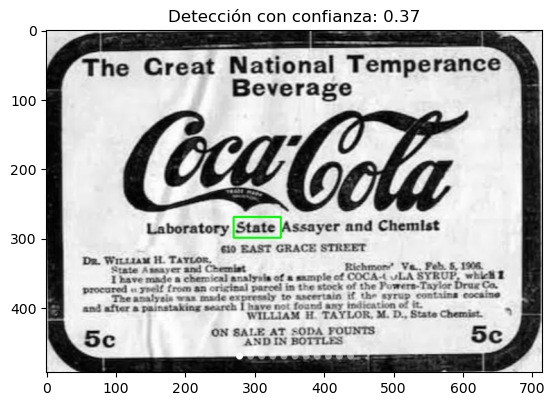

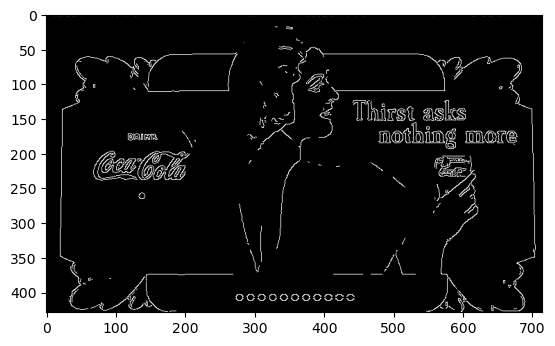

best_match.shape =  (30, 68)


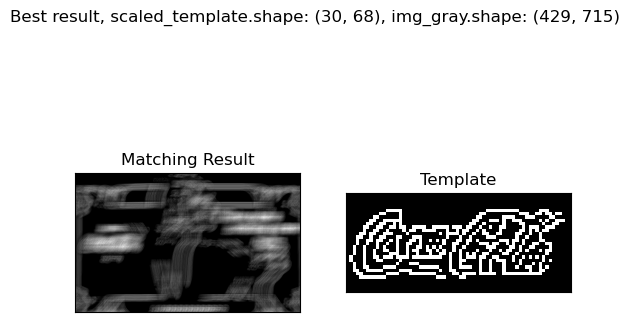

best_match.shape =  (32, 73)


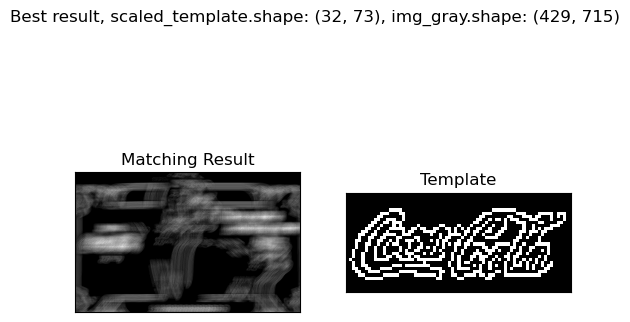

best_match.shape =  (63, 143)


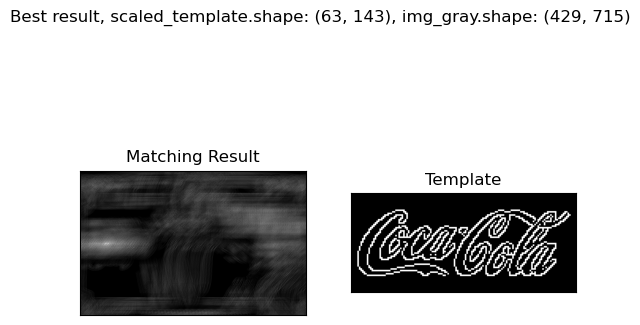

best_match.shape (final) =  (63, 143)


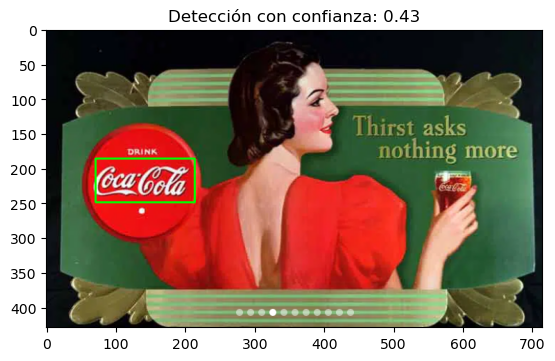

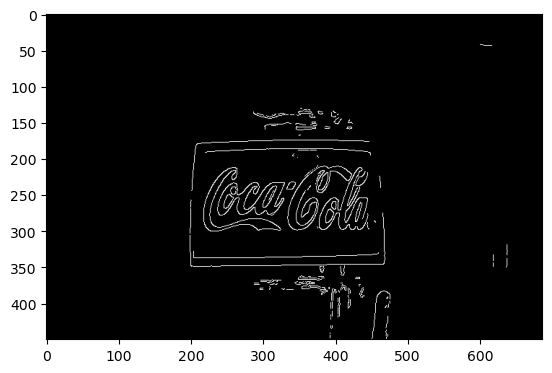

best_match.shape =  (30, 68)


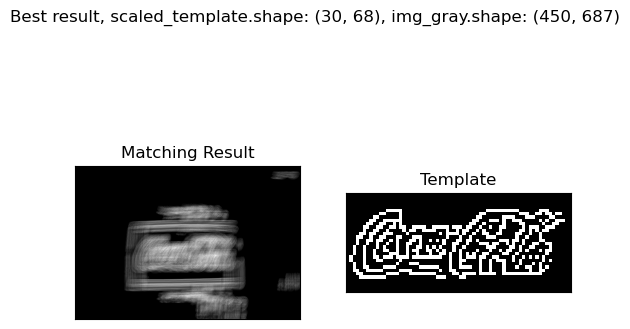

best_match.shape =  (32, 73)


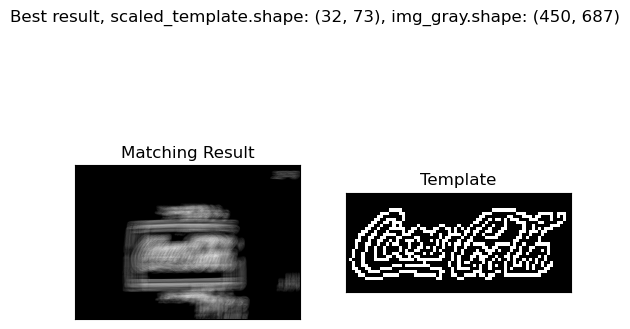

best_match.shape =  (34, 79)


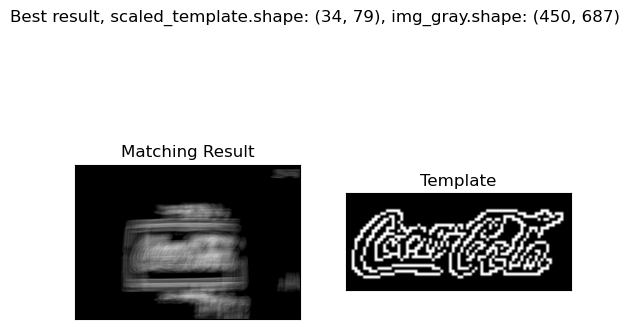

best_match.shape (final) =  (34, 79)


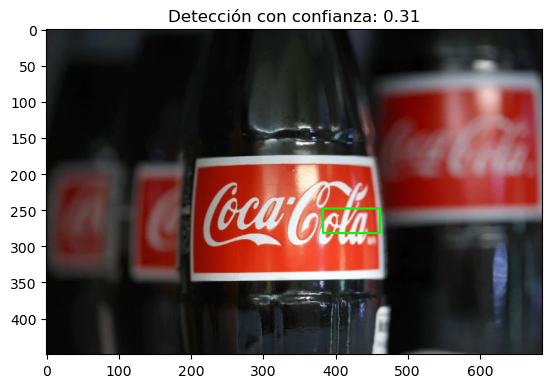

In [138]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

# Ruta a las imágenes y al template
image_paths = glob.glob('./images/*.png')
template_path = './template/pattern.png'

# Cargar el template
template = cv.imread(template_path, 0)
#template = cv.Laplacian(template,cv.CV_8U)
#template = cv.Sobel(template,cv.CV_8U,1,0,ksize=3)
#template = cv.Canny(template, 220, 260, apertureSize = 3)
template_w, template_h = template.shape[::-1]

plt.figure()
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.show()

def detect_logo(image_path, template, min_scale=0.17, max_scale=1.5, scale_step=0.1, threshold=0.10):
    img = cv.imread(image_path)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #img_gray = cv.Laplacian(img_gray,cv.CV_8U)
    #img_gray = cv.Sobel(img_gray,cv.CV_8U,1,0,ksize=3)
    img_gray = cv.Canny(img_gray, 220, 260, apertureSize = 3)
    img_h, img_w = img_gray.shape
    best_match = None
    best_val = -1
    best_loc = None
    best_scale = 1.0

    plt.figure()
    plt.imshow(cv.cvtColor(img_gray, cv.COLOR_BGR2RGB))
    plt.show()
    
    scales = np.linspace(min_scale, max_scale, 100)

    # generamos nuestra "piramide" de tamaños arbitrarios
    for scale in scales:
        scaled_template = cv.resize(template, None, fx=scale, fy=scale)
        #scaled_template = cv.resize(template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
        scaled_template = cv.Canny(scaled_template, 220, 260, apertureSize = 5)
        scaled_template_h, scaled_template_w = scaled_template.shape
        
        # Verificar que el template no sea más grande que la imagen
        if scaled_template_h <= img_h and scaled_template_w <= img_w:
            #res = cv.matchTemplate(img_gray, scaled_template, cv.TM_CCOEFF_NORMED)
            res = cv.matchTemplate(img_gray, scaled_template, cv.TM_CCORR_NORMED)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            
            if max_val > best_val:
                best_val = max_val
                best_loc = max_loc
                best_match = scaled_template
                print('best_match.shape = ', best_match.shape)
                best_scale = scale

                #plt.figure()
                #plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
                #plt.show()

                plt.subplot(121)
                plt.imshow(res, cmap='gray')  # 'aspect' se ajusta para evitar distorsiones
                plt.title('Matching Result')
                plt.xticks([]), plt.yticks([])

                # Imagen original con recuadros
                plt.subplot(122)
                plt.imshow(scaled_template, cmap='gray')  # 'aspect' se ajusta para evitar distorsiones
                plt.title('Template')
                plt.xticks([]), plt.yticks([])

                plt.suptitle(f'Best result, scaled_template.shape: {scaled_template.shape}, img_gray.shape: {img_gray.shape}')
                plt.show()
                
    
    if best_val >= threshold:
        print('best_match.shape (final) = ', best_match.shape)
        best_w, best_h = best_match.shape[::-1]
        top_left = best_loc
        bottom_right = (top_left[0] + best_w, top_left[1] + best_h)
        cv.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
        confidence = best_val
        return img, confidence
    else:
        return img, None

# Mostrar resultados
for image_path in image_paths:
    detected_img, confidence = detect_logo(image_path, template)

    plt.figure()
    plt.imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGB))
    if confidence:
        plt.title(f'Detección con confianza: {confidence:.2f}')
    else:
        plt.title('No se detectó el logotipo')
    plt.show()
